# LMS Exploration | 9. Movie_Recommendation_System

---

**[Introduce]**  

우리가 좋아할 만한 영화를 추천받아봅시다!

MovieLens Dataset을 implicit 데이터로 간주하고 MF모델을 구성하고,
implicit 패키지의 AlternatingLeastSquares 모델으로 학습해봅니다. 


**[Data]**  

* 추천시스템의 MNIST,  [Movielens 데이터]((https://files.grouplens.org/datasets/movielens/ml-1m-README.txt))
* 유저가 영화에 대해 평점을 매긴 데이터 중 MovieLens 1M Dataset 사용합니다.


    These files contain 1,000,209 anonymous ratings of approximately 3,900 movies   
    made by 6,040 MovieLens users who joined MovieLens in 2000.  


* 별점 데이터는 대표적 explicit 데이터이지만 implicit 데이터로 간주하고 테스트 해보겠습니다.
* 별점을 시청횟수로 해석합니다.
* 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외합니다.

**[Preparation]**

심볼릭 링크로 연결
```python
$ mkdir -p ~/aiffel/recommendata_iu/data/ml-1m
$ ln -s ~/data/ml-1m/* ~/aiffel/recommendata_iu/data/ml-1m
```

# 1. 데이터 준비와 전처리


Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔히 정리되어 있습니다.  

    1-0. 데이터 불러오기
    1-1. 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외
    1-2. 별점을 시청횟수로 해석
    1-3. 영화 제목이 담긴 메타 데이터 읽어오기


### 1-0. 데이터 불러오기

#### Ratings file Description
All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [1]:
import os 
import pandas as pd

In [2]:
rating_file_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding="ISO-8859-1")
original_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


[pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)
```
engine : {‘c’, ‘python’}, optional
Parser engine to use. The C engine is faster while the python engine is currently more feature-complete.

encoding : str, optional
Encoding to use for UTF when reading/writing (ex. ‘utf-8’). 

UTF-8은 모든 유니 코드 문자를 나타낼 수있는 멀티 바이트 인코딩인 반면, ISO 8859-1은 첫 256 개의 유니 코드 문자를 나타낼 수있는 1 바이트 인코딩이다. 둘 다 ASCII를 정확히 같은 방식으로 인코딩한다.
ISO-8859-1 : 8 비트. 256 개의 코드 포인트.
UTF-8 : 8-32 비트 (1-4 바이트). 코드 포인트 1,112,064 개

LMS 에서 ISO-8859-1 로 인코딩하는 이유??

```
[UTF-8 v. ISO-8859-1](https://www.python2.net/questions-83433.htm)

### 1-1. 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외

In [3]:
#- 3점 이상만 남기기

ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'original_data_size: {original_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / original_data_size:.2%}')

original_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


### 1-2. 별점을 시청횟수로 해석

In [4]:
#- rating 컬럼의 이름을 count로 바꾸기

ratings.rename(columns={'rating':'count'}, inplace=True)

### 1-3. 영화 제목이 담긴 메타 데이터 읽어오기

**MOVIES FILE DESCRIPTION**

Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist


In [5]:
movie_file_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre']
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies['genre'].unique()

array(["Animation|Children's|Comedy", "Adventure|Children's|Fantasy",
       'Comedy|Romance', 'Comedy|Drama', 'Comedy',
       'Action|Crime|Thriller', "Adventure|Children's", 'Action',
       'Action|Adventure|Thriller', 'Comedy|Drama|Romance',
       'Comedy|Horror', "Animation|Children's", 'Drama',
       'Action|Adventure|Romance', 'Drama|Thriller', 'Drama|Romance',
       'Thriller', 'Action|Comedy|Drama', 'Crime|Drama|Thriller',
       'Drama|Sci-Fi', 'Romance', 'Adventure|Sci-Fi', 'Adventure|Romance',
       "Children's|Comedy|Drama", 'Documentary', 'Drama|War',
       'Action|Crime|Drama', 'Action|Adventure', 'Crime|Thriller',
       "Animation|Children's|Musical|Romance", 'Action|Drama|Thriller',
       "Children's|Comedy", 'Drama|Mystery', 'Sci-Fi|Thriller',
       'Action|Comedy|Crime|Horror|Thriller', 'Drama|Musical',
       'Crime|Drama|Romance', 'Adventure|Drama', 'Action|Thriller',
       "Adventure|Children's|Comedy|Musical", 'Action|Drama|War',
       'Action|Adventur

각 영화가 단순히 하나의 장르로 표현되는 것이 아니라 다양한 장르의 조합으로 표현됨을 알 수 있습니다.


# 2. MF(Matrix Factorization) 모델 구성
- MF의 목적은 Matrix Complement 로, 아직 평가를 내리지 않은 user-item의 빈 공간을 Model-based Learning으로 채워넣는 것입니다.
- 유저간, 혹은 아이템간 유사도를 이용하는 Memory-based 방법과 달리, MF는 행렬 인수 분해라는 수학적 방법으로 접근합니다. 
- 행렬은 두개의 하위 행렬로 분해가 가능하며, 다시 곱해져서 원래 행렬과 동일한 크기의 단일 행렬이 될 수 있다는 성질을 이용하는 것입니다.
- 행렬 인수 분해의 원칙은 비평가 항목을 채우기 위함입니다.

    1-0. 사전만들기
    1-1. 내가 선호하는 영화 6가지를 골라 rating에 추가하기
    1-2. CSR matrix 만들기

참고 : [efficient way to create a dictionary of two pandas Dataframe columns](https://stackoverflow.com/questions/17426292/what-is-the-most-efficient-way-to-create-a-dictionary-of-two-pandas-dataframe-co)

### 1-0. 사전만들기
   
movie_id : genre  
movie_name : movie_id  
movie_id : movie_name  


In [7]:
movie_id_to_genre = pd.Series(movies.genre.values, index=movies.movie_id).to_dict()
movie_id_to_genre_show = pd.Series(movie_id_to_genre)
movie_id_to_genre_show.head(5)

1     Animation|Children's|Comedy
2    Adventure|Children's|Fantasy
3                  Comedy|Romance
4                    Comedy|Drama
5                          Comedy
dtype: object

In [8]:
movie_to_idx = pd.Series(movies.movie_id.values,index=movies.title).to_dict()

movie_id_idx_show = pd.Series(movie_to_idx)
movie_id_idx_show.head(5)

Toy Story (1995)                      1
Jumanji (1995)                        2
Grumpier Old Men (1995)               3
Waiting to Exhale (1995)              4
Father of the Bride Part II (1995)    5
dtype: int64

In [9]:
idx_to_movie = {v:k for k,v in movie_to_idx.items()}

idx_to_movie_show = pd.Series(idx_to_movie)
idx_to_movie_show.head(5)

1                      Toy Story (1995)
2                        Jumanji (1995)
3               Grumpier Old Men (1995)
4              Waiting to Exhale (1995)
5    Father of the Bride Part II (1995)
dtype: object

* ratings에 있는 유니크한 영화 개수
* rating에 있는 유니크한 사용자 수
* 가장 인기 있는 영화 30개(인기순)

In [10]:
num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()
print(f'number of unique users: {num_user}, number of unique movies: {num_movie}')

number of unique users: 6039, number of unique movies: 3628


In [11]:
temp_movie_data = ratings['movie_id'].map(idx_to_movie.get)

movie_name_ratings = ratings.copy() #- movie_id 를 영화 이름으로 변환할 df 생성
movie_name_ratings['movie_id'] = temp_movie_data
movie_count = movie_name_ratings.groupby('movie_id')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

movie_id
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257

#- 또는 movies df 와 ratings df 병합
movie_id_count = ratings.groupby('movie_id')['user_id'].count()
movie_id_count.sort_values(ascending=False).head(30)
data = pd.merge(movies,movie_id_count, how='inner',on='movie_id')
data.head(10)

### 1-1. 내가 선호하는 영화 6가지를 골라 rating에 추가하기

In [12]:
my_favorite_movie = [ 'Terminator 2: Judgment Day (1991)', 'Matrix, The (1999)', 'Toy Story (1995)', 'Men in Black (1997)', 'Good Will Hunting (1997)','Silence of the Lambs, The (1991)']
my_favorite = list(map(movie_to_idx.get, my_favorite_movie))
my_favorite

[589, 2571, 1, 1580, 1704, 593]

In [13]:
my_favorite_genre = map(movie_id_to_genre.get, my_favorite)
my_favorite_movie_show = pd.DataFrame(data = list(zip(my_favorite, my_favorite_movie, my_favorite_genre )),columns = ['영화 ID','영화 이름', '영화 장르'])
my_favorite_movie_show.set_index('영화 ID', inplace = True)
my_favorite_movie_show

,영화 이름,영화 장르
영화 ID,,
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1,Toy Story (1995),Animation|Children's|Comedy
1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi
1704,Good Will Hunting (1997),Drama
593,"Silence of the Lambs, The (1991)",Drama|Thriller


In [14]:
my_movielist = pd.DataFrame({'user_id' : ['61616']*6, 'movie_id': my_favorite, 'count':[5]*6, 'timestamp':[0]*6 })

In [15]:
if not ratings.isin({'user_id':['61616']})['user_id'].any(): 
    ratings = ratings.append(my_movielist)
ratings.tail(10)

,user_id,movie_id,count,timestamp
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569
0,61616,589,5,0
1,61616,2571,5,0
2,61616,1,5,0
3,61616,1580,5,0
4,61616,1704,5,0
5,61616,593,5,0


<class 'pandas.core.series.Series'>


Text(59000, 500, 'my ID')

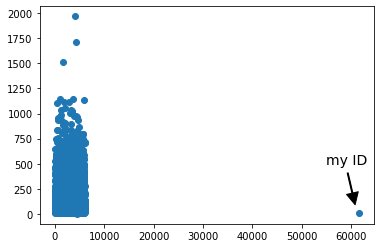

In [16]:
import matplotlib.pyplot as plt
freq = ratings['user_id'].value_counts()
print(type(freq))
plt.scatter(freq.index, freq.values)
plt.annotate('my ID', xy=(61000, 50), xytext=(59000,500),
            fontsize=14, ha='center',
            arrowprops=dict(facecolor='black', width=1, shrink=0.1))

### 1-2. CSR matrix 만들기
평가행렬에는 유저 수 X 영화 수 만큼의 정보가 포함되어, 유저가 본 적이 없는 영화에 대한 정보까지도 모두 행렬에 포함되어 계산되게 됩니다. 약 3900 개의 영화 중에서 유저가 본 적이 없는 영화는 절반 이상일 것이고, 수많은 값이 0 으로 채워질 것입니다. 이러한 행렬을 Sparse Matrix라고 합니다. 이때 발생하는 메모리 낭비를 최소화하기 위해서는 유저가 시청한 영화에 대해서만 정보만을 저장하면서 전체 행렬 형태를 유추할 수 있는 데이터 구조가 필요합니다.
**CSR Matrix**는 Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조입니다.  

```python
num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()
```

In [17]:
ratings.dtypes

user_id      object
movie_id      int64
count         int64
timestamp     int64
dtype: object

In [18]:
ratings=ratings.astype('int64')
ratings.dtypes

user_id      int64
movie_id     int64
count        int64
timestamp    int64
dtype: object

from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings['count'], (ratings.user_id, ratings.movie_id)), shape = (num_user, num_movie))
csr_data

```
csr_data = csr_matrix((ratings['count'], (ratings.user_id, ratings.movie_id)), shape = (num_user, num_movie))

ValueError: row index exceeds matrix dimensions
```
왜일까...?

In [19]:
print(ratings.shape)
print(num_user, num_movie)

(836484, 4)
6039 3628


In [20]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings['count'], (ratings.user_id, ratings.movie_id)))
csr_data

<61617x3953 sparse matrix of type '<class 'numpy.longlong'>'
	with 836484 stored elements in Compressed Sparse Row format>

# 3. 학습 | Alternating Least Squares 
- implicit 패키지는 이전 스텝에서 설명한 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지입니다.
- 이 패키지에 구현된 als(AlternatingLeastSquares) 모델을 사용해보겠습니다.
- **Matrix Factorization**에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식이 효과적인 것으로 알려져 있습니다.

[AlternatingLeastSquares ](https://implicit.readthedocs.io/en/stable/als.html)
```
A Recommendation Model based of the algorithms described in the paper ‘Collaborative Filtering for Implicit Feedback Datasets’ with performance optimizations described in ‘Applications of the Conjugate Gradient Method for Implicit Feedback Collaborative Filtering.’  


AlternatingLeastSquares 클래스의 __init__ 파라미터

1. factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지 
2. regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지 
3. use_gpu : GPU를 사용할 것인지
4. iterations : epochs와 같은 의미


1,4를 늘릴수록 학습데이터를 잘 학습하게 되지만 과적합의 우려가 있음..!
```

In [21]:
from implicit.als import AlternatingLeastSquares
import numpy as np

#- implicit 라이브러리에서 권장하는 부분
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [22]:
#- Implicit AlternatingLeatSquares 모델의 선언

als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

user_id 를 0616 으로 설정했을 때 invalid token error 가 발생했습니다. 왜? 

In [23]:
#- als 모델은 input으로 item X user 꼴의 matrix를 받기 때문에 Transpose 해줘야 함.

csr_data_transpose = csr_data.T
csr_data_transpose

<3953x61617 sparse matrix of type '<class 'numpy.longlong'>'
	with 836484 stored elements in Compressed Sparse Column format>

In [24]:
#- 모델 훈련

als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

# 4. 모델학습 후 추론

훈련된 모델이 예측한 나의 선호도 알아보기. 내가 선호하는 6가지 영화와 그 외의 영화의 선호도를 비교해보자. 

In [25]:
my_favorite_ratings = {}
for movie_id in my_favorite:
    name_vector, movie_vector = als_model.user_factors[616], als_model.item_factors[movie_id]
    my_favorite_ratings[idx_to_movie[movie_id]] = np.dot(name_vector, movie_vector)

my_favorite_movie_show['선호도']=my_favorite_ratings.values()
my_favorite_movie_show.sort_values(by=["선호도"], ascending=False, inplace=True) 
my_favorite_movie_show

,영화 이름,영화 장르,선호도
영화 ID,,,
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.969780
1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.850184
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.386817
593,"Silence of the Lambs, The (1991)",Drama|Thriller,0.035222
1,Toy Story (1995),Animation|Children's|Comedy,-0.005882
1704,Good Will Hunting (1997),Drama,-0.118814


In [26]:
popular_movie_count = movie_count.sort_values(ascending=False)[:20]
popular_movie_count
my_ratings = {}
for movie in popular_movie_count.index:
    if movie in my_favorite_movie:
        continue
    
    name_vector, movie_vector = als_model.user_factors[616], als_model.item_factors[movie_to_idx[movie]]
    my_ratings[movie] = np.dot(name_vector, movie_vector)

popular_movie_name =list(my_ratings.keys())
popular_movie_id = list(map(movie_to_idx.get, popular_movie_name))
popular_movie_genre = list(map(movie_id_to_genre.get, popular_movie_id))
popular_movie_rating = list(my_ratings.values())

my_ratings = pd.DataFrame(data = zip(popular_movie_id,popular_movie_name,popular_movie_genre,popular_movie_rating), columns=['영화 ID','영화 이름','영화 장르','선호도'])
my_ratings.set_index('영화 ID', inplace = True)
my_ratings.sort_values(by=["선호도"], ascending=False, inplace=True) 
my_ratings

,영화 이름,영화 장르,선호도
영화 ID,,,
2858,American Beauty (1999),Comedy|Drama,1.004743
480,Jurassic Park (1993),Action|Adventure|Sci-Fi,1.003363
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.911757
110,Braveheart (1995),Action|Drama|War,0.902171
1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.819157
1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.718101
1198,Raiders of the Lost Ark (1981),Action|Adventure,0.594565
1270,Back to the Future (1985),Comedy|Sci-Fi,0.411765
2028,Saving Private Ryan (1998),Action|Drama|War,0.311123


### 4-1. 유사한 영화 추출하기

In [27]:
similar_movie = als_model.similar_items(2571, N=15) #- 2571 Matrix, The (1999)
similar_movie

[(2571, 0.9999999),
 (589, 0.79444236),
 (2916, 0.67642117),
 (1240, 0.5959546),
 (457, 0.5805028),
 (480, 0.5578379),
 (1527, 0.5430725),
 (1580, 0.5216258),
 (32, 0.49416628),
 (1573, 0.485606),
 (1610, 0.4717347),
 (260, 0.42777717),
 (1200, 0.4029182),
 (1196, 0.4010139),
 (1214, 0.38361022)]

In [28]:
similar_movie_name = [idx_to_movie[i[0]] for i in similar_movie]
similar_movie_id = [i[0] for i in similar_movie]
similar_movie_genre = [movie_id_to_genre[i[0]] for i in similar_movie]
similarity = [i[1] for i in similar_movie]
similar_movie_df = pd.DataFrame(data=zip(similar_movie_id,similar_movie_name,similar_movie_genre,similarity), columns = ['movie_id','similar_movie','genre','similarity'])
similar_movie_df.set_index('movie_id', inplace = True)
similar_movie_df

,similar_movie,genre,similarity
movie_id,,,
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1.000000
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.794442
2916,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller,0.676421
1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,0.595955
457,"Fugitive, The (1993)",Action|Thriller,0.580503
480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.557838
1527,"Fifth Element, The (1997)",Action|Sci-Fi,0.543073
1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.521626
32,Twelve Monkeys (1995),Drama|Sci-Fi,0.494166


장르로 비교해보장 

In [59]:
def get_similar_movie(movie_name: str, N=10):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id, N)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

In [60]:
def get_similar_movie_df(movie_name: str, N=10):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id, N)
    similar_movie_name = [idx_to_movie[i[0]] for i in similar_movie]
    similar_movie_id = [i[0] for i in similar_movie]
    similar_movie_genre = [movie_id_to_genre[i[0]] for i in similar_movie]
    similarity = [i[1] for i in similar_movie]
    similar_movie_df = pd.DataFrame(data=zip(similar_movie_id,similar_movie_name,similar_movie_genre,similarity), columns = ['movie_id','similar_movie','genre','similarity'])
    similar_movie_df.set_index('movie_id', inplace = True)
    return similar_movie_df

In [32]:
get_similar_movie_df('Toy Story 2 (1999)')

,similar_movie,genre,similarity
movie_id,,,
3114,Toy Story 2 (1999),Animation|Children's|Comedy,1.000000
1,Toy Story (1995),Animation|Children's|Comedy,0.796427
2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,0.674487
2761,"Iron Giant, The (1999)",Animation|Children's,0.446793
34,Babe (1995),Children's|Comedy|Drama,0.425183
588,Aladdin (1992),Animation|Children's|Comedy|Musical,0.381037
3157,Stuart Little (1999),Children's|Comedy,0.377081
2687,Tarzan (1999),Animation|Children's,0.370559
2396,Shakespeare in Love (1998),Comedy|Romance,0.369465


In [34]:
get_similar_movie_df('Silence of the Lambs, The (1991)')

,similar_movie,genre,similarity
movie_id,,,
593,"Silence of the Lambs, The (1991)",Drama|Thriller,1.000000
318,"Shawshank Redemption, The (1994)",Drama,0.798309
608,Fargo (1996),Crime|Drama|Thriller,0.780658
296,Pulp Fiction (1994),Crime|Drama,0.704844
1213,GoodFellas (1990),Crime|Drama,0.570715
527,Schindler's List (1993),Drama|War,0.535196
50,"Usual Suspects, The (1995)",Crime|Thriller,0.534454
2762,"Sixth Sense, The (1999)",Thriller,0.492808
1704,Good Will Hunting (1997),Drama,0.477075


### 4-2.내가 좋아할만한 영화 추천받기

In [35]:
movie_recommended = als_model.recommend(61616, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(480, 0.568191),
 (318, 0.46655643),
 (2762, 0.43373555),
 (110, 0.43173155),
 (2028, 0.42443904),
 (2916, 0.42124486),
 (608, 0.4078626),
 (457, 0.40663472),
 (3114, 0.38830373),
 (296, 0.3413638),
 (32, 0.33932525),
 (527, 0.33758718),
 (1240, 0.30716217),
 (34, 0.29396164),
 (1610, 0.29350206),
 (1265, 0.27651995),
 (1270, 0.27199167),
 (1358, 0.26027757),
 (50, 0.2534731),
 (2355, 0.24985792)]

In [36]:
def get_recommended_movie_df(user_id, N=20):
    '''parameter N is number of recommendation'''
    movie_recommended = als_model.recommend(user_id, csr_data, N=N, filter_already_liked_items=True)
    recommended_movie_name = [idx_to_movie[i[0]] for i in movie_recommended]
    recommended_movie_id = [i[0] for i in movie_recommended]
    recommended_movie_genre = [movie_id_to_genre[i[0]] for i in movie_recommended]
    recommendation = [i[1] for i in movie_recommended]
    recommended_movie_df = pd.DataFrame(data=zip(recommended_movie_id,recommended_movie_name,recommended_movie_genre,recommendation), columns = ['movie_id','recommended_movie','genre','recommendation'])
    recommended_movie_df.set_index('movie_id', inplace = True)
    return recommended_movie_df

In [37]:
my_recommendation = get_recommended_movie_df(61616, 20)
my_recommendation

,recommended_movie,genre,recommendation
movie_id,,,
480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.568191
318,"Shawshank Redemption, The (1994)",Drama,0.466556
2762,"Sixth Sense, The (1999)",Thriller,0.433736
110,Braveheart (1995),Action|Drama|War,0.431732
2028,Saving Private Ryan (1998),Action|Drama|War,0.424439
2916,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller,0.421245
608,Fargo (1996),Crime|Drama|Thriller,0.407863
457,"Fugitive, The (1993)",Action|Thriller,0.406635
3114,Toy Story 2 (1999),Animation|Children's|Comedy,0.388304


### 4-3. 추천 기여도 살펴보기

In [38]:
def explain_recommendation_df(user_id, recommended_movie_id):
    explain = als_model.explain(user_id, csr_data, itemid=recommended_movie_id)
    explain_movie_name = [idx_to_movie[i[0]] for i in explain[1]]
    explain_movie_id = [movie_to_idx[i] for i in explain_movie_name]
    explain_movie_genre = [movie_id_to_genre[i] for i in explain_movie_id]
    explainatory = [i[1] for i in explain[1]]
    explain_recommendation_df = pd.DataFrame(data=zip(explain_movie_id,explain_movie_name,explain_movie_genre,explainatory), columns = ['movie_id','movie','genre','explanatory'])
    explain_recommendation_df.set_index('movie_id', inplace = True)
    return explain_recommendation_df

In [39]:
explain_my_recommendation = explain_recommendation_df(61616, 480)
explain_my_recommendation 

,movie,genre,explanatory
movie_id,,,
1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.285804
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.211731
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.099853
1704,Good Will Hunting (1997),Drama,0.010627
593,"Silence of the Lambs, The (1991)",Drama|Thriller,-0.022769
1,Toy Story (1995),Animation|Children's|Comedy,-0.025183


# 5. 추천시스템 평가하기 | Mean Average Precision(MAP)
Mean Average Precision(MAP)은 
* 정보를 순서를 지정하여(Ranked) 반환하는 경우에 사용하는 평가방법
* 예를들어 구글과 같은 검색엔진에서 검색결과가 검색의도와 관련도가 높은 순으로 잘 나열되어있는지를 평가하는 방법입니다.

* 추천시스템은 수많은 아이템 중에 사용자가 관심을 보일만한 아이템들을 보여준며 가장 자신있는 것을 첫 번째로 보여준다는 점에서 검색엔진과 의미가 동일하며 따라서 MAP은 추천시스템의 평가방법으로도 유용합니다.

평가 지표중 하나인 precision 및 recall 값은 순서를 고려하지 않지만, MAP은 순서를 고려하기 위해 K값을 설정합니다. 

    Precision : 우리가 추천한 아이템 중에 사용자가 정말 관심있어하는 아이템의 비율  
    Recall : 실제로 사용자가 관심있어하는 아이템 중에 우리가 추천한 아이템의 비율  



In [40]:
def mean_reciprocal_rank(rs):
    """Score is reciprocal of the rank of the first relevant item
    First element is 'rank 1'.  Relevance is binary (nonzero is relevant).
    Example from http://en.wikipedia.org/wiki/Mean_reciprocal_rank
    >>> rs = [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.61111111111111105
    >>> rs = np.array([[0, 0, 0], [0, 1, 0], [1, 0, 0]])
    >>> mean_reciprocal_rank(rs)
    0.5
    >>> rs = [[0, 0, 0, 1], [1, 0, 0], [1, 0, 0]]
    >>> mean_reciprocal_rank(rs)
    0.75
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean reciprocal rank
    """
    rs = (np.asarray(r).nonzero()[0] for r in rs)
    return np.mean([1. / (r[0] + 1) if r.size else 0. for r in rs])


def r_precision(r):
    """Score is precision after all relevant documents have been retrieved
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> r_precision(r)
    0.33333333333333331
    >>> r = [0, 1, 0]
    >>> r_precision(r)
    0.5
    >>> r = [1, 0, 0]
    >>> r_precision(r)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        R Precision
    """
    r = np.asarray(r) != 0
    z = r.nonzero()[0]
    if not z.size:
        return 0.
    return np.mean(r[:z[-1] + 1])


def precision_at_k(r, k):
    """Score is precision @ k
    Relevance is binary (nonzero is relevant).
    >>> r = [0, 0, 1]
    >>> precision_at_k(r, 1)
    0.0
    >>> precision_at_k(r, 2)
    0.0
    >>> precision_at_k(r, 3)
    0.33333333333333331
    >>> precision_at_k(r, 4)
    Traceback (most recent call last):
        File "<stdin>", line 1, in ?
    ValueError: Relevance score length < k
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Precision @ k
    Raises:
        ValueError: len(r) must be >= k
    """
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)


def average_precision(r):
    """Score is average precision (area under PR curve)
    Relevance is binary (nonzero is relevant).
    >>> r = [1, 1, 0, 1, 0, 1, 0, 0, 0, 1]
    >>> delta_r = 1. / sum(r)
    >>> sum([sum(r[:x + 1]) / (x + 1.) * delta_r for x, y in enumerate(r) if y])
    0.7833333333333333
    >>> average_precision(r)
    0.78333333333333333
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Average precision
    """
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)


def mean_average_precision(rs):
    """Score is mean average precision
    Relevance is binary (nonzero is relevant).
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1]]
    >>> mean_average_precision(rs)
    0.78333333333333333
    >>> rs = [[1, 1, 0, 1, 0, 1, 0, 0, 0, 1], [0]]
    >>> mean_average_precision(rs)
    0.39166666666666666
    Args:
        rs: Iterator of relevance scores (list or numpy) in rank order
            (first element is the first item)
    Returns:
        Mean average precision
    """
    return np.mean([average_precision(r) for r in rs])


def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


if __name__ == "__main__":
    import doctest
    doctest.testmod()

    

SyntaxError: unexpected EOF while parsing (<ipython-input-40-05f440b73ed9>, line 193)